In [ ]:
from pathlib import Path
import numpy as np
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import json

In [ ]:
# --- Configuration ---
OUTPUT_DIR = Path('../notebooks/output')
CHUNK_FILES = list(OUTPUT_DIR.glob('*_chunks.jsonl'))
print(f"Found {len(CHUNK_FILES)} chunk file(s):", [p.name for p in CHUNK_FILES])

Found 1 chunk file(s): ['AI_Training_Document_cleaned_chunks.jsonl']
Loaded 3 chunks from AI_Training_Document_cleaned_chunks.jsonl

Encoding with all-MiniLM-L6-v2 ...


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Shape: (3, 384)

Encoding with paraphrase-mpnet-base-v2 ...


c:\Users\91966\Downloads\AI_model_2\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\91966\.cache\huggingface\hub\models--sentence-transformers--paraphrase-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed.

Shape: (3, 768)


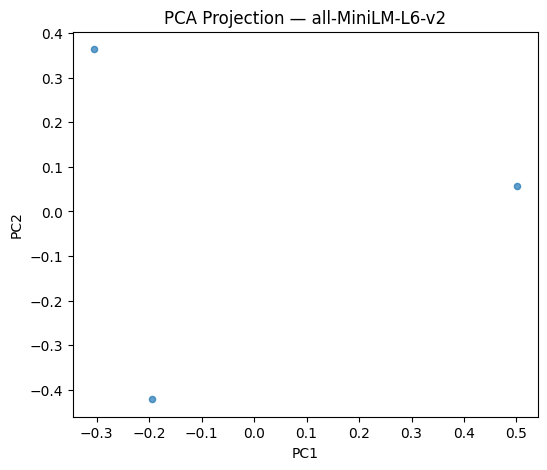

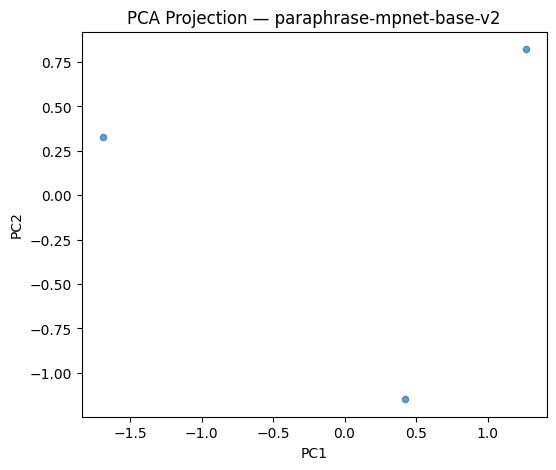


Query Chunk (index 0):
 User Agreement 
1. Introduction 
This User Agreement, the Mobile Application Terms of Use, and all policies and additional terms 
posted on and in our sites, applications, tools, and services (collectively "Services") set out the terms 
on which eBay ...

Top 5 similar chunks:
Score: 1.0000 | Chunk #0
User Agreement  1. Introduction  This User Agreement, the Mobile Application Terms of Use, and all policies and additional terms  posted on and in our sites, applications, tools, and services (collect ...

Score: 0.6866 | Chunk #1
It also contains an Agreement to Arbitrate which will, with limited  exception, require you to submit claims you have against us or related third parties to binding and  final arbitration, unless you  ...

Score: 0.6286 | Chunk #2
Unless otherwise  expressly provided, eBay has no control over and does not guarantee: the existence, quality, safety,  or legality of items advertised; the truth or accuracy of users' content or list ...


Sav

In [ ]:

# --- Load chunks ---
def load_chunks(path: Path):
    chunks = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            chunks.append(json.loads(line))
    return chunks


if CHUNK_FILES:
    sample_path = CHUNK_FILES[0]
    chunks = load_chunks(sample_path)
    texts = [c['text'] for c in chunks]
    print(f"Loaded {len(texts)} chunks from {sample_path.name}")


# --- Choose models to compare ---
MODELS = [
'all-MiniLM-L6-v2', # fast, compact, widely used
'paraphrase-mpnet-base-v2' # more accurate, slower
]


embeddings_data = {}


# --- Compute embeddings for each model ---
for model_name in MODELS:
    print(f"\nEncoding with {model_name} ...")
    model = SentenceTransformer(model_name)
    emb = model.encode(texts, show_progress_bar=True, convert_to_numpy=True)
    embeddings_data[model_name] = emb
    print(f"Shape: {emb.shape}")


# --- Visualize embeddings with PCA ---
for model_name, emb in embeddings_data.items():
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(emb)


    plt.figure(figsize=(6,5))
    plt.scatter(reduced[:,0], reduced[:,1], s=20, alpha=0.7)
    plt.title(f'PCA Projection — {model_name}')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()


# --- Compare cosine similarity between chunks ---
from sklearn.metrics.pairwise import cosine_similarity


if MODELS and texts:
    sample_idx = 0
    query_text = texts[sample_idx]


    model = SentenceTransformer(MODELS[0])
    query_emb = model.encode([query_text], convert_to_numpy=True)
    all_emb = embeddings_data[MODELS[0]]


    sims = cosine_similarity(query_emb, all_emb)[0]
    top_idx = np.argsort(sims)[::-1][:5]


    print(f"\nQuery Chunk (index {sample_idx}):\n", query_text[:250], '...')
    print("\nTop 5 similar chunks:")
    for i in top_idx:
        print(f"Score: {sims[i]:.4f} | Chunk #{i}")
        print(texts[i][:200].replace('\n',' '), '...\n')


# --- Save results for reuse ---
for model_name, emb in embeddings_data.items():
    np.save(OUTPUT_DIR / f"embeddings_{model_name.replace('/', '_')}.npy", emb)
print("\nSaved embedding arrays for reuse.")
